# Chapter 3: More Image Manipulation

## More Image Manipulation with PIL

### Simulating Lens Blur Effects

In [82]:
from PIL import ImageFilter

image = Image.open('images/me8.jpg').convert('RGB')
mask = Image.open('images/mask.png').convert('L')
p = 0.5
r = 5
gammaCorrectedImage = image.point(lambda x: x ** p)  ## Or whatever power works for you.
bokeh = gammaCorrectedImage.filter(ImageFilter.GaussianBlur(radius=r)) #ImageFilter.BLUR)
bokeh = bokeh.point(lambda x: x ** (1/p)) # To get back the original gamma.
bokeh = Image.composite(image, bokeh, mask)
blurImage = image.filter(ImageFilter.GaussianBlur(radius=r)) #ImageFilter.BLUR) # #
blurImage = Image.composite(image, blurImage, mask)
finalImage = lighter(bokeh, blurImage) 
finalImage.show()

![](images/me8_lblur.jpg)

### Radial Blur

Radial blur is a photographic and image processing technique where the center of an image is in focus while the surrounding areas appear blurred in a radial pattern. This effect is often used to convey a sense of motion or to draw attention to a specific point in the image.

In [ ]:
# Define width and height of image
W, H = 650, 650

# Create solid red image
im = Image.new(mode='RGB', size=(W,H), color=(255,255,255))

# Create radial alpha/transparency layer. 255 in centre, 0 at edge
Y = np.linspace(-1, 1, H)[None, :]*255
X = np.linspace(-1, 1, W)[:, None]*255
alpha = np.sqrt(X**2 + Y**2)
alpha = 255 - np.clip(0,255,alpha)

# Push that radial gradient transparency onto red image and save
im.putalpha(Image.fromarray(alpha.astype(np.uint8)))
im1 = Image.open('images/me8.jpg').convert('RGBA')
im2 = Image.alpha_composite(im1, im.resize(im1.size))

im2.show()

### Interchanging Image Color Palettes

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

img1, img2 = Image.open('images/parrot.jpg'), Image.open('images/lena.jpg')
img1_p = img.convert("P", palette=Image.ADAPTIVE, colors=16)
img1_p.save('images/parrot_adaptive16_orig.png')
img2_p = img2.convert("P", palette=Image.ADAPTIVE, colors=16)
img2_p.save('images/lena_adaptive16_orig.png')

print(os.stat('images/parrot.jpg').st_size, os.stat('images/parrot_adaptive16_orig.png').st_size)
data = list(img1_p.getdata())
print(data[50:70])
clrs = img1_p.getcolors()
print(len(clrs))

# show up colors and palette
pal1 = img1_p.getpalette()
pal2 = img2_p.getpalette()

p_nzero = pal1[:len(clrs) * 3]
clrs.sort(key=lambda x: x[1])  # sort by color, for showing
for v in [(clrs[i // 3], (p_nzero[i], p_nzero[i + 1], p_nzero[i + 2]))
    for i in range(0, len(p_nzero), 3)]:
        print(v)

img1_p.putpalette(pal2)
img1_p.save('images/parrot_adaptive16_remapped.png')
img2_p.putpalette(pal1)
img2_p.save('images/lena_adaptive16_remapped.png')

### Generating Image with PIL

`PIL` can be used to generate images of the following types:

* Mandelbrot set: with the function `effect_mandelbrot()`, covering the given extent. The parameters it accepts are 
   * `size`: the requested size in pixels, as a 2-tuple: (width, height).
   * `extent`: the extent to cover, as a 4-tuple: (x0, y0, x1, y1).
   * `quality`: quality of the image.

* Gaussian noise of size (256 x 256) centered around (128 x 128): with the function `effect_noise()`. The parameters it accepts are
    * `size`: the requested size in pixels, as a 2-tuple: (width, height).
    * `sigma`: standard deviation of noise.

* 256x256 linear gradient from black to white, top to bottom: with the function `linear_gradient()`, accepting the parameter `mode` (input mode).

* 256x256 radial gradient from black to white, centre to edge: witj the function `radial_gradient()`, again accepting the parameter `mode` (input mode).

The next code snippet demonstrates the generation of the images.

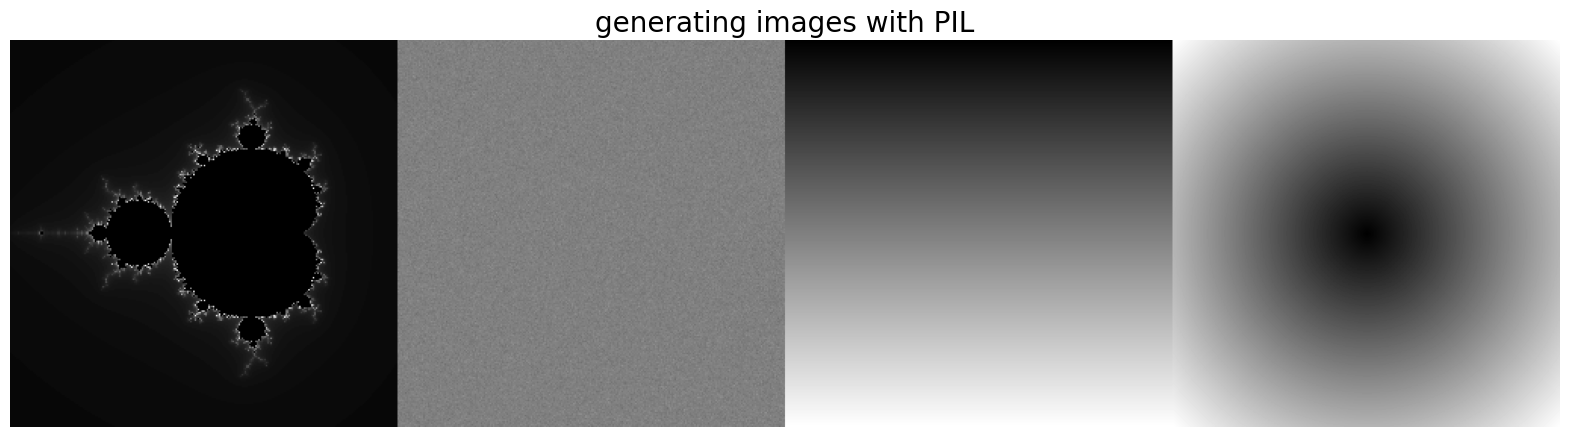

In [114]:
from PIL.Image import effect_mandelbrot, effect_noise, linear_gradient, radial_gradient

sz = (256, 256)
plt.figure(figsize=(20,8))
plt.imshow(np.hstack((
                    effect_mandelbrot(size=sz, extent=(-2, -1.5, 1, 1.5), quality=100),
                    effect_noise(size=sz, sigma=5),
                    linear_gradient(mode='L'),
                    radial_gradient(mode='L')
            )))
plt.axis('off')
plt.title('generating images with PIL', size=20)
plt.show()

## Image Manipulation with `opencv-python`

### Simulate fish-eye effect

In [ ]:
from typing import Type

def apply_fisheye_effect(img: np.ndarray, K: np.ndarray, d: np.ndarray) -> np.ndarray:
    
    indices = np.array(np.meshgrid(range(img.shape[0]), range(img.shape[1]))).T \
                .reshape(np.prod(img.shape[:2]), -1).astype(np.float32)

    Kinv = np.linalg.inv(K)
    indices1 = np.zeros_like(indices, dtype=np.float32)
    for i in range(len(indices)):
        x, y = indices[i]
        indices1[i] = (Kinv @ np.array([[x], [y], [1]])).squeeze()[:2]
    indices1 = indices1[np.newaxis, :, :]
    
    in_indices = cv2.fisheye.distortPoints(indices1, K, d)
    indices, in_indices = indices.squeeze(), in_indices.squeeze()

    distorted_img = np.zeros_like(img)
    for i in range(len(indices)):
        x, y = indices[i]
        ix, iy = in_indices[i]
        if (ix < img.shape[0]) and (iy < img.shape[1]):
            distorted_img[int(ix),int(iy)] = img[int(x),int(y)]
    in_indices = in_indices.astype(int)
    #distorted_img  = distorted_img[np.min(in_indices[:,0]):np.max(in_indices[:,0]), np.min(in_indices[:,1]):np.max(in_indices[:,1])]
    #plt.imsave('images/chess_distorted.png', distorted_img)
    return distorted_img

K = np.array( [[338.37324094,0,319.5],[0,339.059099,239.5],[0,0,1]],dtype=np.float32) # camera intrinsic params
d = np.array([0.17149, -0.27191, 0.25787, -0.08054],dtype=np.float32) # k1, k2, k3, k4 - distortion coefficients

img = plt.imread('images/parrot.jpg')
img = img / img.max()
distorted_img = apply_fisheye_effect(img, K, d)

plt.figure(figsize=(12,5))
plt.subplot(121), plt.imshow(img, aspect='auto'), plt.axis('off'), plt.title('original', size=20)
plt.subplot(122), plt.imshow(distorted_img, aspect='auto'), plt.axis('off'), plt.title('distorted', size=20)
plt.tight_layout()
plt.show()

### Remove fish-eye distortion

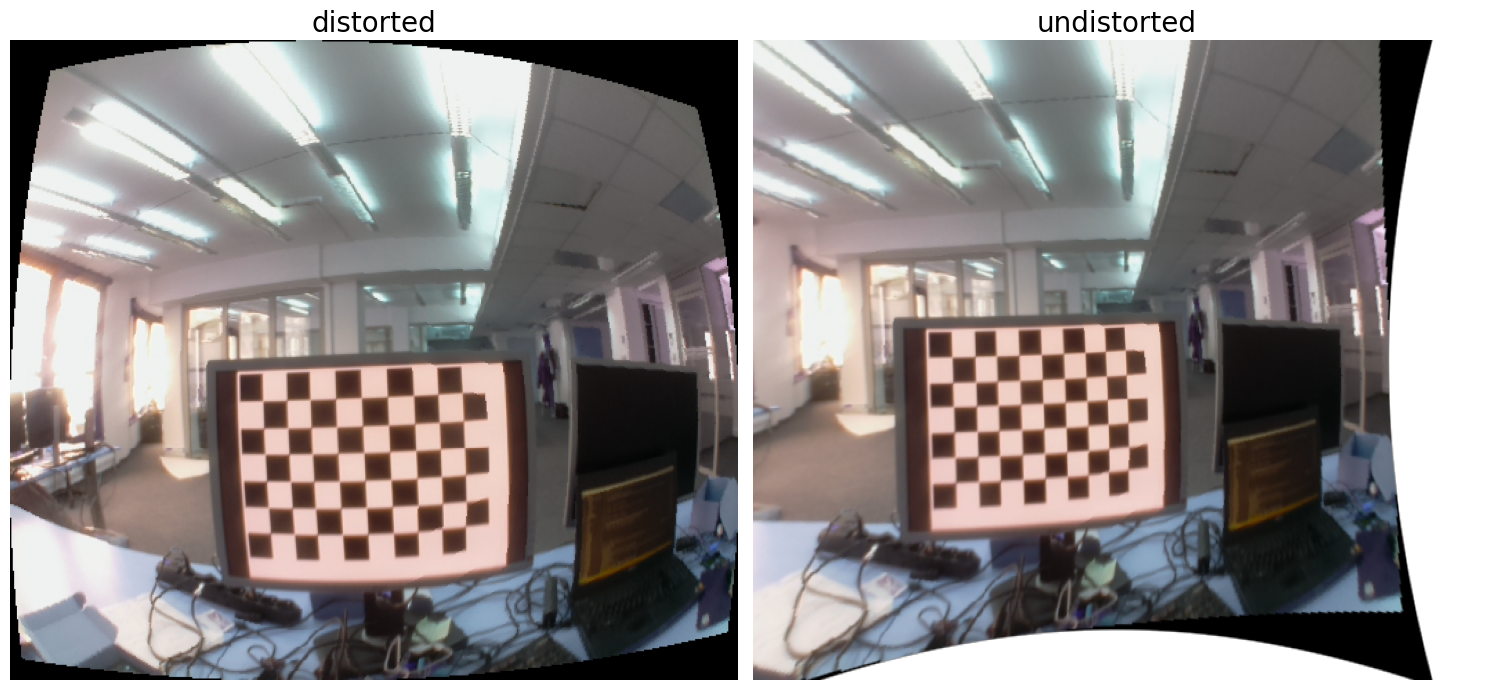

In [371]:
# https://stackoverflow.com/questions/67257397/opencv-undistortpoints-doesnt-undistort?noredirect=1&lq=1
# https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

# camera parameters, to be computed during callibration
K = np.array( [[338.37324094,0,319.5],[0,339.059099,239.5],[0,0,1]],dtype=np.float64)
D = np.array( [[ 0.01794191], [-0.12190366],[ 0.14111533],[-0.09602948]],dtype=np.float64)
new_size = (640, 480)

Knew = K.copy()
#alpha = 0.6
#Knew, roi = cv2.getOptimalNewCameraMatrix(K, D, new_size, alpha, new_size,centerPrincipalPoint = True)
    
unfishmap1, unfishmap2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), Knew, new_size, cv2.CV_32F)

#img = cv2.imread('images/3FYUT.jpg') 
img = plt.imread('images/chess_distorted.png')
img_undistorted = cv2.remap(img, unfishmap1, unfishmap2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT) 

x, y, w, h = roi
#img_undistorted = img_undistorted[y:y+h, x:x+w]

plt.figure(figsize=(15,7))
plt.subplot(121), plt.imshow(img, aspect='auto'), plt.axis('off'), plt.title('distorted', size=20)
plt.subplot(122), plt.imshow(img_undistorted, aspect='auto'), plt.axis('off'), plt.title('undistorted', size=20)
plt.tight_layout()
plt.show()

### with `defisheye`

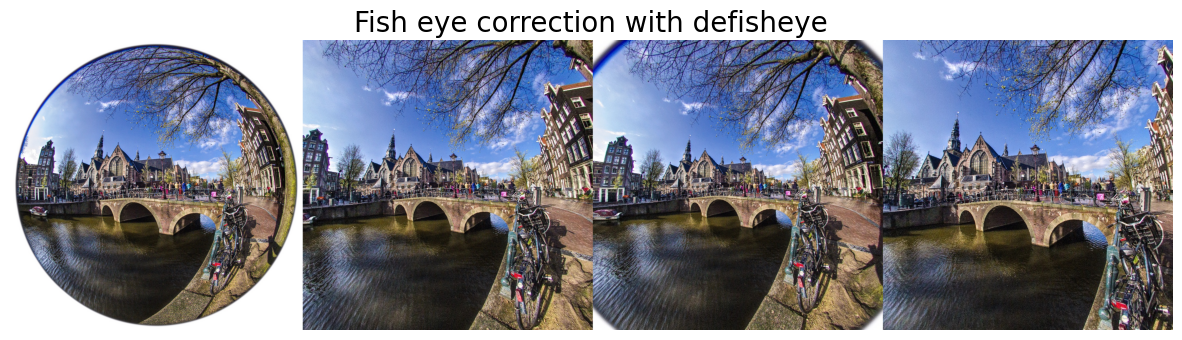

In [356]:
from defisheye import Defisheye

dtype = 'linear'
format = 'fullframe'
fov = 180
pfov = 120

img = "images/fishy.jpeg"

dtypes = ['linear', 'equalarea', 'stereographic']
cor_imgs = []
for dtype in dtypes:
    #img_out = f"images/out/example3_{dtype}_{format}_{pfov}_{fov}.jpg"
    obj = Defisheye(img, dtype=dtype, format=format, fov=fov, pfov=pfov)
    # To save image locally 
    #obj.convert(outfile=img_out)
    cor_img = obj.convert()
    #print(cor_img.shape)
    cor_imgs.append(cv2.cvtColor(cor_img, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((plt.imread(img), cor_imgs[0], cor_imgs[1], cor_imgs[2]))), plt.axis('off')
plt.title('Fish eye correction with defisheye', size=20)
plt.show()

### Homography - a Geometric Image Transformation

Homography refers to a mathematical transformation that maps points in one plane to corresponding points in another plane. In computer vision and image processing, homography is often used to describe the transformation between two images of the same scene taken from different viewpoints or under different perspectives.

A homography matrix (H) is a $3\times 3$ matrix that represents the linear transformation between two planes in projective geometry. It can be used to map the coordinates of points in one image to their corresponding coordinates in another image.

Let's now learn how to implement homogtaphy (perspective image transformation) with `opencv-python` and `skimage.transform` module functions (and compare their performance).

### with `opencv-python`

The function `cv2.getPerspectiveTransform()` can be used to compute the perspective transformation matrix. This matrix can be used to perform a perspective transformation on an image. Here are the steps how it can be used to implement homography.

* First You need to have four pairs of corresponding points in the source and destination coordinate spaces. Each pair should be a tuple of $(x, y)$ coordinates, as shown in the next code snippet.

In [97]:
im_src = (imread('images/books.jpg'))
height, width, dim = im_src.shape
src = np.array([[267., 364.],
       [312., 683.],
       [555., 598.],
       [561., 284.]], dtype='float32')
dst = np.array([[   0.,    0.],
       [0, height-1],
       [width-1, height-1],
       [width-1, 0.]], dtype='float32')

def plot_images(src, dst):
    plt.figure(figsize=(7,7))
    plt.subplot(121), plt.imshow(src), plt.axis('off'), plt.title('Source image', size=15)
    plt.subplot(122), plt.imshow(dst), plt.axis('off'), plt.title('Destination image', size=15)
    plt.tight_layout()
    plt.show()

* Use `cv2.getPerspectiveTransform()` to compute the perspective transformation matrix based on the corresponding points. The `perspective_matrix` is a 3x3 matrix that represents the perspective transformation.
* Once you have the perspective transformation matrix, you can use it to transform coordinates or warp an image, using the function `cv2.warpPerspective()`.

In [99]:
%timeit M = cv2.getPerspectiveTransform(src, dst)
%timeit im_dst = cv2.warpPerspective(im_src, M, (width, height), flags=cv2.INTER_LINEAR)
#plot_images(im_src, im_dst)

4.22 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.21 ms ± 385 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### with `scikit-image.transform.warp()`

The `skimage.transform.warp()` function can be used to apply geometric transformations to images. It is a versatile function that allows you to specify a transformation function or a precomputed transformation matrix. The function `skimage.transform.warp()` performs backward transformation, whereas `cv2.warpPerspective()` demonstrated earlier performs forward transformation. 

The function accepts the input (source) `image` along with an inverse coordinate map `inverse_map` argument, which transforms coordinates in the output image into their corresponding coordinates in the input image (this can be obtained by taking an inverse of the transforation matrix `M`).

You can specify the interpolation method used during the transformation by setting the `order` parameter, the default  interpolation method being `'nearest'`.

In [436]:
%timeit im_dst = warp(im_src, np.linalg.inv(M), clip=False)
#plot_images(im_src, im_dst)

136 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### with `scikit-image.transform.ProjectiveTransform`

In `scikit-image`, `ProjectiveTransform` is a class that represents a 2D projective transformation, which can be used to perform geometric transformations on images, such as rotation, scaling, translation, and skewing. You create an instance of `ProjectiveTransform` by providing a transformation matrix. 

* The transformation matrix ($3 \times 3$) can also be estimated using the `estimate()` method of `ProjectiveTransform`. It estimates the transformation matrix $M$ from a set of corresponding points (from the source and destination images). The parameters are determnied with the total least-squares method. Number of source and destination coordinates must match. Finally, use the `inverse()` method to return a transform object representing the inverse.

* The function `warp_persective()` in the next code snippet (defined with **type annotations**) again implements the homography. 

* It first estimates the `inverse_map` from the set of matching points `src_pts` and `dst_pts` from the sources and destination images, respectively. 

* Then it uses the inverse transformation to obtain the source indices corresponding to the destination images (it also clips the coordinates). 

* Finally, the destination images are obtained by selecting the pixels from the source image using the source indices obtained. Effectively, it implements the `warp()` function. 

The next code snippet demonstrates how the function works, with the following figure representing the input image warped to produce the output as shown. 

149 ms ± 25.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


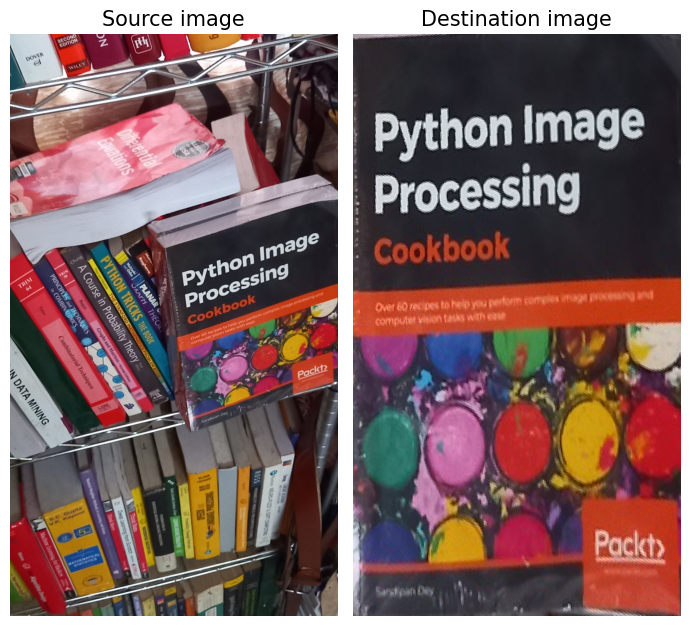

In [102]:
def warp_projective(src_pts: np.ndarray, dst_pts: np.ndarray, im_src: np.ndarray) -> np.ndarray:
    src, dst = src_pts[:, [1, 0]], dst_pts[:, [1, 0]]
    pt = ProjectiveTransform()
    pt.estimate(src, dst)
    x, y = np.mgrid[:height, :width]
    dst_indices = np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) 
    src_indices = np.round(pt.inverse(dst_indices), 0).astype(int)
    valid_idx = np.where((src_indices[:,0] < height) & (src_indices[:,1] < width) & (src_indices[:,0] >= 0) & (src_indices[:,1] >= 0))
    dst_indicies_valid = dst_indices[valid_idx]
    src_indicies_valid = src_indices[valid_idx]
    im_dst = np.zeros_like(im_src)
    im_dst[dst_indicies_valid[:,0],dst_indicies_valid[:,1]] = im_src[src_indicies_valid[:,0],src_indicies_valid[:,1]]
    return im_dst.astype(np.uint8) 
    
%timeit im_dst = warp_projective(src, dst, im_src)
plot_images(im_src, im_dst)

### Flip images

Flipping an image involves reversing the order of pixels along a particular axis, either horizontally or vertically. This operation is akin to looking at the image in a mirror or turning it upside down. This geometric transformation can be implemented using the function `cv2.flip()` from the library `opencv-python`. This function accepts the input image. along with a `filpCode`, which is an integer specifying the direction of flip, as described below.

* A horizontal flip (`flipCode=0`) involves reversing the order of pixels along the vertical axis. Pixels on the left side of the image swap places with pixels on the right side. 
* A vertical flip (`flipCode=1`) involves reversing the order of pixels along the horizontal axis. Pixels at the top of the image exchange positions with pixels at the bottom.
* Both Horizontal and Vertical Flip (`flipCode=-1`): This operation involves both a horizontal and vertical flip, effectively turning the image 180 degrees.

### Image Manipulation with `scipy.ndimage` module

We can use the `nbdimage` module from the library `scipy` too for image manipulation, the next
section shows couple of examples.

### Applying an Affine Transformation to an Image

We can use the function `affine_transform()` and provide the 3 x 3 transformation matrix (in
homogeneous coordinates) and the offset, to carry out the transformation, as shown in the
next code block.

In [ ]:
im = imread("images/parrot.png")
transformed = affine_transform(im, [[np.cos(np.pi/4),np.sin(np.pi/4), 0],[-np.sin(np.pi/4),np.cos(np.pi/4), 0], [0,0,1]],
offset=[-im.shape[0]/2+75, im.shape[1]/2-50, 0], output_shape=im.shape)
plt.imshow(transformed), plt.axis('off')
plt.show()

### Zooming an image

The next code block demonstrates how to use the `zoom()` function from the `scipy.ndimage`
module to zoom in and then crop a portion of image using numpy ndarray slicing. The next figure shows the output of the code block.

In [ ]:
im = imread('images/parrot.jpg') / 255
zoomed_im = ndimage.zoom(im, (2,2,1), mode='nearest', order=1) # no zoom on color channel, order of the spline interpolation = 1
print(im.shape, zoomed_im.shape)
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(im,aspect='auto'), plt.title('Original Image', size=20)
plt.subplot(122), plt.imshow(zoomed_im[150:400,350:650,:], aspect='auto') # crop the enlarged face
plt.title('Zoomed and Cropped Image', size=20)
plt.tight_layout()
plt.show()

### Interpolating an Image

Now, you will see how the same function `ndimage.zoom()` can be used to zoom the small clock image twice with spline interpolation of different orders. The next figure plots the outputs obtained and also shows that output image with interpolation of order $4$ spline interpolation obtains a much better apprximation of the resized image (much sharper, hence contains much more details) than the one obtained with order $1$.

In [ ]:
im = imread('images/clock.png')
n = 2
interp_images = []
for k in range(1,5):
    zoomed_im = ndimage.zoom(im, (n,n,1), mode='nearest', order=k) # no zoom on color channel, order of the spline interpolation = 1
    interp_images.append(zoomed_im) 
interp_images.append(interp_images[-1]-interp_images[0])
plt.figure(figsize=(20,7))
plt.imshow(np.hstack(interp_images)), plt.axis('off')
plt.title('output with spline interpolation of order 1,2,3,4 and the diff between the last and the first interpolated image', size=20)
plt.show()

### Applying Wave distortion to an image

In [ ]:
im = imread('images/lena.jpg', True)
x,y = np.meshgrid(np.float32(np.arange(im.shape[1])),np.float32(np.arange(im.shape[0])))
y = y + 20*np.sin(x/15)
distorted = ndimage.map_coordinates(im, [y.ravel(),x.ravel()])
plt.imshow(distorted.reshape(im.shape)), plt.axis('off')
plt.show()

## Image Manipulation with wand

`Wand` is a Python binding for `ImageMagick`, a software suite for creating, editing, composing, or converting images. 

In [1]:
!python -VV

Python 3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)]


In [3]:
import os
os.environ['MAGICK_HOME']

'C:\\Program Files\\ImageMagick-7.1.1-Q16-HDRI'

### Creating Visual Effects 

If you're looking to create visual effects using Wand (Python's ImageMagick binding), you can follow these general steps:

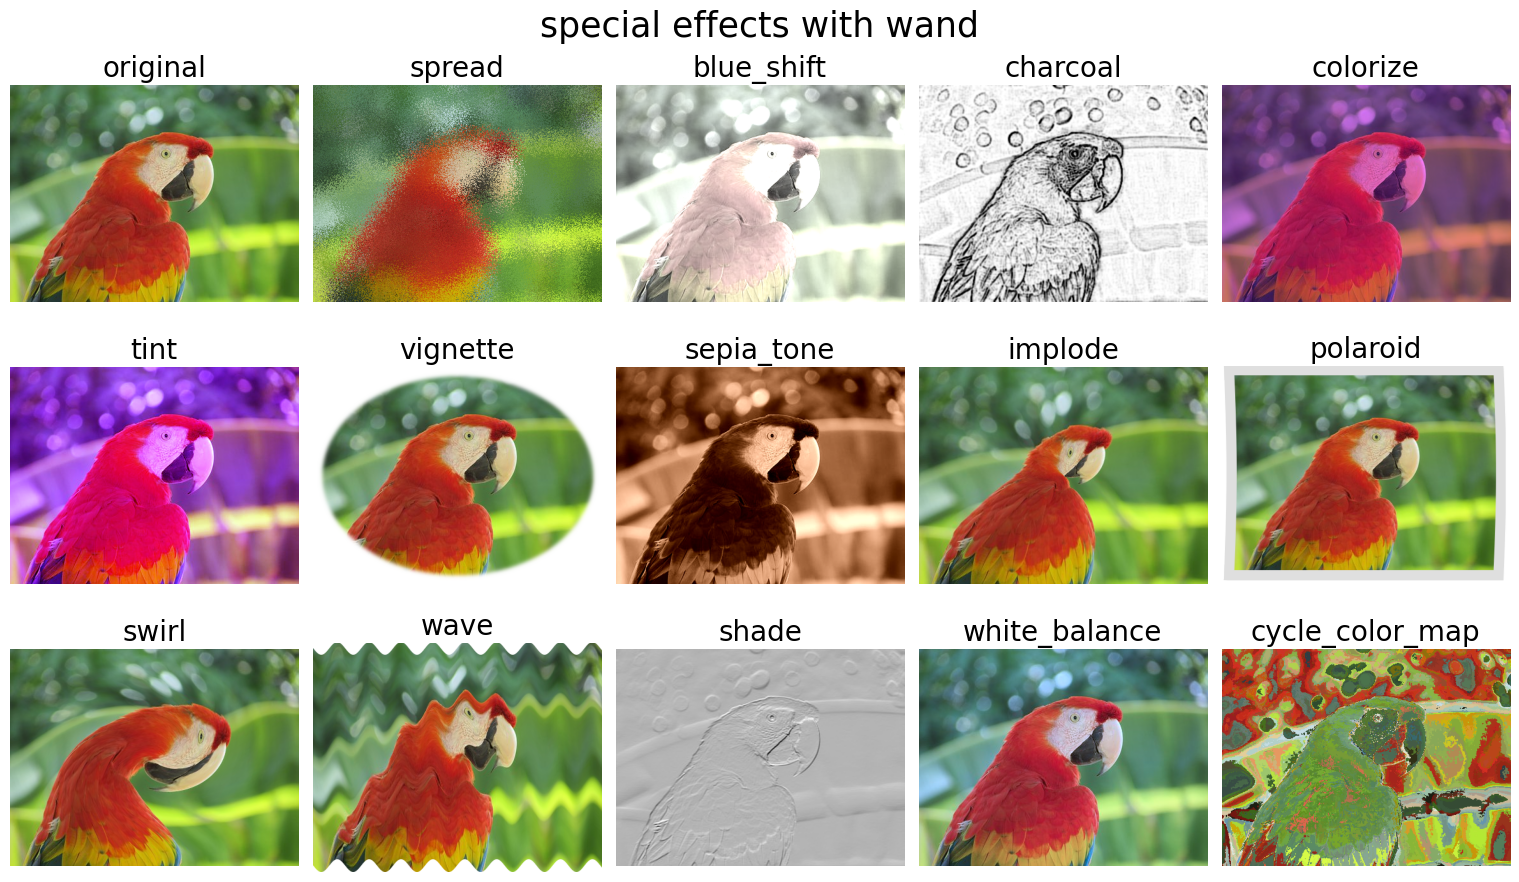

In [97]:
# https://docs.wand-py.org/en/latest/guide/install.html#install-imagemagick-on-windows
# https://imagemagick.org/script/download.php#windows
# https://docs.wand-py.org/en/0.5.9/guide/fx.html#blue-shift
from wand.image import Image as ImageW
from wand.color import Color

def call_func(img, func_name):
    img = img.clone()
    func = getattr(img, func_name)
    arg_dict = functions[func_name]
    func(**arg_dict)
    return img
        
functions = {'spread': {'radius':16.0}, 'blue_shift': {'factor':2}, 
             'charcoal': {'radius':2, 'sigma':1}, 'colorize': {'color': 'magenta', 'alpha':"rgb(10%, 50%, 20%)"},
             'tint': {'color': 'magenta', 'alpha':"rgb(50%, 70%, 80%)"}, 'vignette': {'sigma':3, 'x':15, 'y':15},
             'sepia_tone': {'threshold': 0.9}, 'implode': {'amount':0.5}, 
             'polaroid': {}, 'swirl': {'degree': -120}, 'wave': {'amplitude': 10, 'wave_length':50},
             'shade': {'gray':True, 'azimuth':100.0, 'elevation':45.0}, 'white_balance': {},
             'cycle_color_map': {'offset': 50}
            }

plt.figure(figsize=(15,9))
plt.gray()
plt.subplots_adjust(0,0,1,0.925,0.05,0.05)
with ImageW(filename="images/parrot.png") as img:
    plt.subplot(3,5,1), plt.imshow(np.array(img)), plt.axis('off'), plt.title('original', size=20)
    i = 2
    for func_name in functions:
        out_img = call_func(img, func_name)
        plt.subplot(3,5,i), plt.imshow(np.array(out_img)), plt.axis('off'), plt.title(func_name, size=20)
        i += 1
plt.suptitle('special effects with wand', size=25)
plt.show()

### Sketch, solarize and fx_fliter

In [106]:
with ImageW(filename="images/parrot.png") as img:
    img.transform_colorspace("gray")
    img.sketch(0.6, 0.1, 95.0)

In [107]:
with ImageW(filename="images/parrot.png") as img:
    img.solarize(threshold=0.5 * img.quantum_range)

In [ ]:
fx_filter="(hue > 0.895 || hue < 0.095) ? u : lightness"
with ImageW(filename="images/parrot.png") as img:
    filtered_img = img.fx(fx_filter)        

### Distorting and Undistorting Images

Distorting and undistorting images are common tasks in computer vision and image processing. Distortion can occur due to various factors, such as the lens used to capture the image. Undistorting is the process of correcting these distortions. The most common type of distortion is radial distortion, which causes straight lines to appear curved. Here's a general overview of how to distort and undistort images:

#### Distortion
1. Choose a Distortion Model:
The most common distortion model is radial distortion, which can be modeled using the Brown-Conrady model. This model includes parameters like radial distortion coefficients and tangential distortion coefficients.
2. Compute Distortion:
Use the distortion model parameters to compute the distorted coordinates of each pixel in the image.
3. Apply Distortion:
Map the original pixel coordinates to the distorted coordinates using the computed distortion. This will result in a distorted image.

#### Undistortion
1. Calibrate Camera:
Capture images of a known calibration pattern (e.g., checkerboard) at different orientations and distances. Use these images to calibrate the camera and estimate distortion parameters.
2. Undistort Images:
Apply the distortion parameters to undistort the image. This process involves mapping the distorted pixel coordinates to undistorted coordinates.
3. Use a Library or Framework:
Many computer vision libraries and frameworks, such as OpenCV in Python, provide functions to calibrate cameras and undistort images. 

In this section, we shall simulate a few distortion models using `wand.Image` methods and apply inverse distorion to get the original image back (assuming the parameters for the distortion model known). However, if the paramaters are not known, we need to first estimate the parameters (e.g., using camera calibration), which we shall discuss in later chapters.

### Barrel, Polar, Arc and Shepards distortion

Let's simulate a few different types of geometric distortions that can affect images. Each type of the following distortions has its own characteristics and mathematical models to describe how it distorts an image.

* Barrel Distortion is a type of radial distortion that causes straight lines to curve outward, resembling the shape of a barrel (creates outwards bump), it can be modeled using polynomial equations, and the distortion increases with the distance from the center of the image.

* Polar Distortion, also known as polar transformation or polar warping, involves transforming an image from Cartesian coordinates to polar coordinates. This can result in a circular or radial distortion effect. The mathematical model involves converting Cartesian coordinates (x, y) to polar coordinates (r, θ) and vice versa.

* Arc Distortion involves distorting an image by bending or warping it along a curved path, creating an arched effect.
The mathematical model for arc distortion depends on the specific form of the desired arc or curve.

* Shepard's Distortion, also known as inverse distance weighting (IDW) interpolation, is a spatial interpolation technique. It can be used to distort an image based on the inverse of the distances to neighboring points. Shepard's method uses a mathematical formula to assign weights to neighboring points based on their distances, and the distortion is determined by interpolating values using these weights.

Here we shall use the method `distort()` from `wand.Image` class to apply the above distortions on a given house input image (by passing the distortion names, e.g., `barrel`, `polar` etc., along with the other relevant arguments, e.g., rac angle and rotate angle for `arc` distortion) and plot the corresponding distorted output images obtained, as shown in the next figure, using the following code snippet.

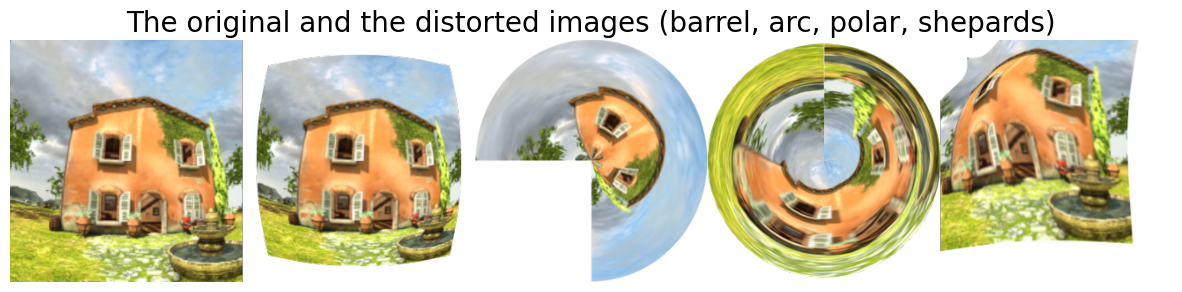

In [61]:
with ImageW(filename='images/house.png') as im:
    w, h = im.size
    im.virtual_pixel = 'transparent' # 'black'
    im_out_barrel = im.clone()
    im_out_barrel.distort('barrel', (0.2, 0.0, 0.0, 1.0))
    im_out.save(filename='images/house_distorted.png')
    im_out_polar = im.clone()
    im_out_polar.distort('polar', (0,)) 
    im_out_arc = im.clone()
    im_out_arc.distort('arc', (270, 45)) # ArcAngle, RotateAngle
    im_out_arc.resize(w,h)
    im_out_shepards = im.clone()
    im_out_shepards.artifacts['distort:viewport'] = "260x260-10+10"
    im_out_shepards.artifacts['shepards:power'] = "4.0"    
    im_out_shepards.distort('shepards', (0, 0, 20, 30, 150, 146, 60, 70))
    im_out_shepards.resize(w,h)
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((np.array(im), np.array(im_out_barrel), 
                          np.array(im_out_arc), np.array(im_out_polar), np.array(im_out_shepards))))
    plt.axis('off'), plt.title('The original and the distorted images (barrel, arc, polar, shepards)', size=20)
    plt.show()

### Correct distortion by Undistorting

You can undo a `barrel` distortion by applying a `barrel_inverse` distortion (which produces an inward bump, to the contrary), using the following code snippet.

In [ ]:
with ImageW(filename='images/house_distorted.png') as im:
    im_out_cor = im.clone()
    im_out_cor.distort('barrel_inverse', (0.2, 0.0, 0.0, 1.0))
    plt.figure(figsize=(9,4))
    plt.imshow(np.hstack((np.array(im), np.array(im_out_cor))))
    plt.axis('off'), plt.title('The distorted and corrected images', size=15)
    plt.show()

### Drawing Convex Hull

The method `Image.convex_hull()` finds the smallest convex polygon, and returns a list of (corner) points of the polygon. In the next code snippet we first obtain the set of points defining the convex hull of the objects in the image using the method `convex_hull()` and then draw a polygon (with red boundary) using those points using the `polygon()` method.

In [ ]:
from wand.drawing import Drawing

with ImageW(filename='images/blocks.png') as img:
    points = img.convex_hull()
    with Drawing() as ctx:
        ctx.fill_color = 'transparent'
        ctx.stroke_color = 'red'
        ctx.polygon(points=points)
        ctx(img)
        plt.imshow(img)

##  Image Manipulation with `matplotlib`

We can use the `pylab` module from the library `matplotlib` for image manipulation, the next
section shows an example.

### Drawing Contour lines for an image

A contour line for an image is a curve connecting all the pixels where they have the same particular (constant) value. If we represent the image as a function $f(x,y)$, where $x$ and $y$ are the spatial coordinates, a contour line corresponds to a set of points $(x,y)$ such that $f(x,y)=constant$.

* The following code snippet shows how to draw the contour lines for the gray-scale image of Einstein, using the function `contour()`, from the module `matplotlib.pylab`.

* The constant levels are specified using the function `np.linspace()`, which creates an array with 15 values, evenly spaced between 0 and 255 (inclusive), to be used as `levels` (constants) for the contour plot. 

* Contour lines can be styled and colored using various parameters such as colors, `cmap` (colormap, here `plt.cm.hot` is used), and `linewidths`. You can fill the regions between contours using `plt.contourf()`.

* You can add labels to the contours using the `plt.clabel()` function. This adds labels to the contours at specified locations (as can be seen from the following figures, the levels 18.2, 36.4, 91.1 are added as labels, these values were generated previsouly using `np.linspace()`).

In [ ]:
#im = color.rgb2gray(imread("images/einstein.jpg")) # read the image from disk as a numpy ndarray
import matplotlib
im = imread("images/einstein.jpg") # read the image from disk as a numpy ndarray
plt.figure(figsize=(10,5))
plt.subplot(131), plt.imshow(im, cmap='gray', aspect='auto'), plt.axis('off'), plt.title('Original Image', size=20)
plt.subplot(132)
cs = plt.contour(np.flipud(im), levels=np.linspace(0,255,15), cmap=plt.cm.hot) 
plt.clabel(cs, fontsize=15, inline=True)
plt.axis('off')
plt.title('Image Contour Lines', size=20)
plt.subplot(133), plt.title('Image Filled Contour', size=20), plt.contourf(np.flipud(im), cmap='inferno'), plt.axis('off')
plt.tight_layout()
plt.show()

Compare `PIL.ImageOp` and `skimage.measure` module's vs. `opencv-python` library's implementation of contour plotting, with the code snippet below.

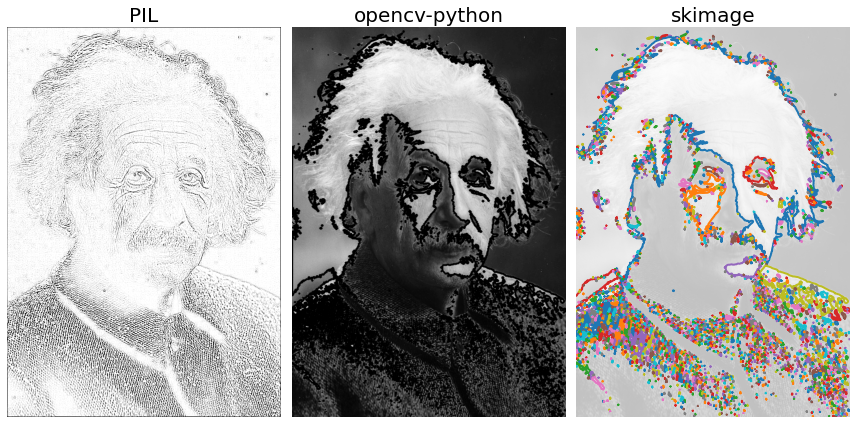

In [31]:
im = Image.open("images/einstein.jpg")
im_ctr = im.filter(ImageFilter.CONTOUR)

im = cv2.imread("images/einstein.jpg")
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(im_gray, 127, 255, 0)
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image=im_gray, contours=contours, contourIdx=-1, color=(0, 0, 0), thickness=2, lineType=cv2.LINE_AA)

im = imread("images/einstein.jpg", True) # read the image from disk as a numpy ndarray
im = im / im.max()
contours = measure.find_contours(im, 0.5) #, fully_connected="high")

plt.figure(figsize=(12,6))
plt.gray()
plt.subplot(131), plt.imshow(im_ctr, aspect='auto'), plt.axis('off'), plt.title('PIL', size=20)
plt.subplot(132), plt.imshow(im_gray, aspect='auto'), plt.axis('off'), plt.title('opencv-python', size=20)
plt.subplot(133), plt.imshow(im, aspect='auto', alpha=0.25), plt.axis('off'), plt.title('skimage', size=20)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.tight_layout()
plt.show()